# Using Neural Networks to solve a Regression problem

In this part, we will try to solve a regression problem only by using Neural Networks. We will implement this in both Pytorch and TensorFlow.

## Pytorch Implementation of the Model

In [1]:
# Import the required libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
import seaborn as sns
import os
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [28]:
if torch.cuda.is_available() :
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

In [3]:
# Now we will import the dataset 
data = pd.read_csv("weatherHistory.csv")
data.head(10)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 05:00:00.000 +0200,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 06:00:00.000 +0200,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 07:00:00.000 +0200,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 08:00:00.000 +0200,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 09:00:00.000 +0200,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


We will build a model to predict the relation of the Pressure with Temperature, Humidity, Wind Speed , Wind Bearing, Visibility and Loud cover.

In [25]:
new_data = data[["Temperature (C)","Humidity",'Wind Speed (km/h)','Wind Bearing (degrees)','Visibility (km)','Loud Cover',"Pressure (millibars)"]]

# Time to create a partition between the training and testing data.
fraction = 0.75
train_data = new_data.sample(frac = fraction, random_state = 1)
testing_data = new_data.drop(index = train_data.index)

In [26]:
# Now let us separate the X data and Y data
x_train = torch.tensor(train_data.iloc[:,:-1].values, dtype = torch.float32)
y_train = torch.tensor(train_data.iloc[:,-1].values, dtype = torch.float32)

x_test = torch.tensor(testing_data.iloc[:,:-1].values, dtype = torch.float32)
y_test = torch.tensor(testing_data.iloc[:,-1].values, dtype = torch.float32)

In [6]:
# We have to create the dataloaders in this part

class Custom(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

In [7]:
# We have to create a Custom Dataset now first before creating the Dataloader object

train = Custom(x_train, y_train)
test = Custom(x_test, y_test)

# Create a DataLoader Object now for both training and testing data

train_loader = DataLoader(train, batch_size = 64, shuffle = True)
test_loader = DataLoader(test, batch_size = 64, shuffle = True)

In [8]:
# Now we will create a model of total 4 layers (6,4,2,1)

class net(nn.Module):
    
    def __init__(self):
        super(net,self).__init__()
        self.layer1 = nn.Linear(6,4)
        self.layer2 = nn.Linear(4,2)
        self.layer3 = nn.Linear(2,1)
        
    def forward(self,x):
        relu = nn.ReLU()
        x1 = relu(self.layer1(x))
        x2 = relu(self.layer2(x1))
        x3 = self.layer3(x2)
        return x3

In [9]:
# Now we will create instances of loss function, optimizer and model

epochs = 100
lr = 0.001
model = net()
model.to(device) # Transfering the model to GPU
optim = torch.optim.Adam(model.parameters(),lr = lr)
loss = nn.MSELoss()
training_loss, testing_loss = [],[]

In [10]:
# Training the Model

for epoch in range(epochs):
    
    train_loss, test_loss = [],[]
    
    for batch_idx, (inputs,target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        if(len(inputs) != 64):
            break
        optim.zero_grad()
        output = torch.squeeze(model(inputs),1)
        loss1 = loss(output, target)
        loss1.backward()
        optim.step()
        train_loss.append(loss1.cpu().detach().numpy())
    
    for batch_idx, (inputs, target) in enumerate(test_loader):
        inputs, target = inputs.to(device), target.to(device)
        if(len(inputs) != 64):
            break
        output1 = torch.squeeze(model(inputs),1)
        loss2 = loss(output1, target)
        test_loss.append(loss2.cpu().detach().numpy())
    training_loss.append(np.array(train_loss).mean())
    testing_loss.append(np.array(test_loss).mean())
         

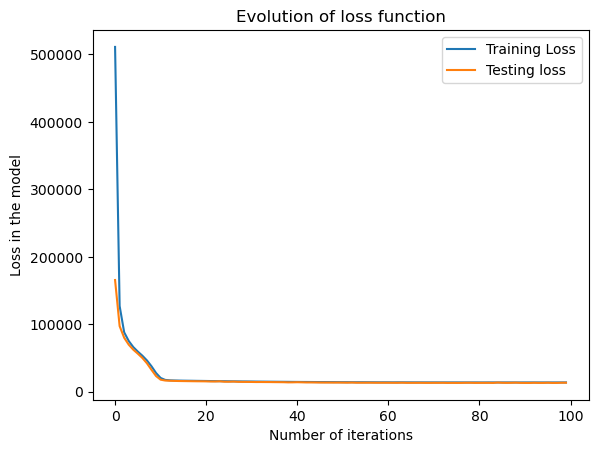

In [11]:
plt.figure()
plt.title("Evolution of loss function")
plt.plot(range(epochs),training_loss, label = "Training Loss")
plt.plot(range(epochs), testing_loss, label = "Testing loss")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Loss in the model")
plt.show()

## TensorFlow Implementation of the Model

In [15]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-11-29 15:20:17.202244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 15:20:17.203394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 15:20:17.203527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [30]:
x_train = tf.convert_to_tensor(train_data.iloc[:,:-1], dtype = tf.float32)
y_train = tf.convert_to_tensor(train_data.iloc[:,-1], dtype = tf.float32)

x_test = tf.convert_to_tensor(testing_data.iloc[:,:-1], dtype = tf.float32)
y_test = tf.convert_to_tensor(testing_data.iloc[:,-1], dtype = tf.float32)

In [17]:
# Time to create a model now 

model_tf = keras.Sequential([ keras.layers.Dense(units = 4, activation = 'relu'),
                           keras.layers.Dense(units = 2, activation = 'relu'),
                          keras.layers.Dense(units =1, activation = 'linear')
                         ])
model_tf.compile(optimizer = 'adam',loss='mean_absolute_error', metrics=['mean_absolute_error'])

In [18]:
history = model_tf.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_data = (x_test,y_test))

Epoch 1/100
 153/2261 [=>............................] - ETA: 2s - loss: 1011.8108 - mean_absolute_error: 1011.8108

2022-11-29 15:20:18.720810: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2261/2261 [==============================] - 3s 1ms/step - loss: 536.0673 - mean_absolute_error: 536.0673 - val_loss: 230.9703 - val_mean_absolute_error: 230.9703
Epoch 2/100
2261/2261 [==============================] - 3s 1ms/step - loss: 197.5936 - mean_absolute_error: 197.5936 - val_loss: 178.5747 - val_mean_absolute_error: 178.5747
Epoch 3/100
2261/2261 [==============================] - 3s 1ms/step - loss: 168.5522 - mean_absolute_error: 168.5522 - val_loss: 159.4974 - val_mean_absolute_error: 159.4974
Epoch 4/100
2261/2261 [==============================] - 3s 1ms/step - loss: 147.2723 - mean_absolute_error: 147.2723 - val_loss: 132.9975 - val_mean_absolute_error: 132.9975
Epoch 5/100
2261/2261 [==============================] - 3s 1ms/step - loss: 107.4217 - mean_absolute_error: 107.4217 - val_loss: 81.0503 - val_mean_absolute_error: 81.0503
Epoch 6/100
2261/2261 [==============================] - 3s 1ms/step - loss: 68.1460 - mean_absolute_error: 68.1460 - val_loss: 61.0809 - v

2261/2261 [==============================] - 3s 1ms/step - loss: 19.2851 - mean_absolute_error: 19.2851 - val_loss: 18.1611 - val_mean_absolute_error: 18.1611
Epoch 49/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.3406 - mean_absolute_error: 19.3406 - val_loss: 18.6292 - val_mean_absolute_error: 18.6292
Epoch 50/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.2496 - mean_absolute_error: 19.2496 - val_loss: 18.6037 - val_mean_absolute_error: 18.6037
Epoch 51/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.2851 - mean_absolute_error: 19.2851 - val_loss: 18.4691 - val_mean_absolute_error: 18.4691
Epoch 52/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.2731 - mean_absolute_error: 19.2731 - val_loss: 18.2341 - val_mean_absolute_error: 18.2341
Epoch 53/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.2663 - mean_absolute_error: 19.2663 - val_loss: 19.2288 - val_mean_absol

Epoch 96/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.2840 - mean_absolute_error: 19.2840 - val_loss: 18.4548 - val_mean_absolute_error: 18.4548
Epoch 97/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.3446 - mean_absolute_error: 19.3446 - val_loss: 18.1301 - val_mean_absolute_error: 18.1301
Epoch 98/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.2444 - mean_absolute_error: 19.2444 - val_loss: 18.7700 - val_mean_absolute_error: 18.7700
Epoch 99/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.3342 - mean_absolute_error: 19.3342 - val_loss: 18.1203 - val_mean_absolute_error: 18.1203
Epoch 100/100
2261/2261 [==============================] - 3s 1ms/step - loss: 19.2747 - mean_absolute_error: 19.2747 - val_loss: 18.2176 - val_mean_absolute_error: 18.2176


In [19]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

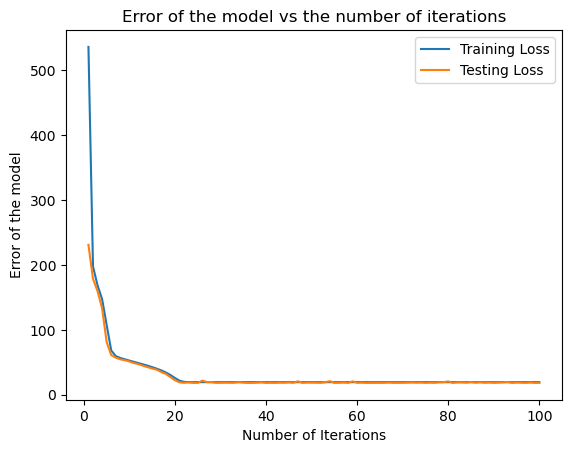

In [20]:
plt.figure()
plt.title("Error of the model vs the number of iterations")
plt.plot(range(1,101), train_loss, label = "Training Loss")
plt.plot(range(1,101), val_loss, label = "Testing Loss")
plt.xlabel("Number of Iterations")
plt.ylabel("Error of the model")
plt.legend()
plt.show()